In [1]:
import tqdm
import sklearn
import numpy as np
import pandas as pd
import pyedflib

In [ ]:
"""
明确一下任务：
1.对visit1的前3000条数据进行清洗
1.1把wake的ECG数据拿出来,对长度进行观察并进行取舍，最好能决定最终用多长的片段并且给它切好
1.2把表中每个患者的AHI拿出来，根据某一个界限标准将人的症状二分类
    **关键在于找到具有说服力的标准，AASM
    1.2首先先把那个AASM的文章看了

2.胎心数据那个把异常数据的情况搞清楚，可视化一下，方便问就行

##但是其实如果能识别呼吸暂停和低通气这两个事件不是更好吗，但你要注意，呼吸暂停和低通气是睡眠中的事件，而你现在要做的是利用
睡前的ECG也就是根本不存在这些事件的ECG对患者症状轻重进行预测，而我们相信这个预测可以成功的基础在于患有OSA的ECG数据会在睡前表现出
一些目前无法被现代医学识别的特征，所以你的模型其实是在识别这些新的，未被发现的特征，所以只能用端对端的方式进行训练，也就是说，我们必须
根据AHI指数或者别的什么将患者进行分类，而比较有说服力的分类自然是采用官方的分类，因此本身标准是什么并不重要，重要的是得有一个标准。

##那这样的话会有问题，二分类是不是一个好的分类，将连续性变量转成离散型变量，恐怕二分类并不是好的分类，那能否这么干，将target就设成AHI
，我们不去做离散变量的分类，我们去拟合到AHI上，最后进行预测的时候加个输出层就好了，那其实那这个思路可以训练多个模型拟合到不同的参数上
最后对这些参数进行一个全连接输出。可是难道直接二分类的模型算法本身不会学到这些吗，理论上如果假设算法模型的功能无限强，甚至可能端对端的
效果要好于教授学习的效果，因为你无法保证计算机是不是在这个过程中还发现了人没有发现的特征。

这是一个很难想出来的问题，直观感觉上好像拟合AHI跟合理，或者说这个任务逻辑性更清晰，更好学习。但直接端对端你算法强了好像也无妨。不妨两个
都试试
"""

In [2]:
data_summary_visit1=pd.read_csv('/data/0shared/linzenghui/numom2b/datasets/numom-visit1-dataset-0.3.1.csv')
#data_summary_visit3=pd.read_csv('/data/0shared/linzenghui/numom2b/datasets/numom-visit3-dataset-0.3.1.csv')

In [3]:
data_summary_visit1.head(n=5)

,publicid,stdyvis,crace,age_at_stdydt,ga_at_stdydt,height,weight,bmi,stdytype_f1t3,unitid_f1t3,...,pctdursp_salt75_f1t3,ahi_ap0nhp3x5x4nhp5x3n_f1t3,ahi_ap0nhp3x3n_f1t3,ahi_ap0nhp3x4n_f1t3,pctdursp_ap0n_f1t3,pctdursp_hp3x0n_f1t3,pctdursp_ap3nhp3x3n_f1t3,maxdurap_hp3x0n_f1t3,avgdurhp_hp3x0n_f1t3,avgspo2baseline_f1t3
0,00001U,1,3,29,12.000000,154.9,69.399633,28.923732,1,125,...,0.0,0.00,0.18,0.00,0.00,0.07,0.07,15.0,15.00,97.1967
1,00004O,1,3,21,12.285714,167.0,66.678078,23.908379,1,410,...,0.0,0.14,0.14,0.14,0.05,2.65,0.00,23.0,12.18,95.5082
2,00008G,1,1,30,11.142857,175.0,83.914588,27.400682,1,55,...,0.0,0.66,1.10,0.66,0.00,3.93,0.48,37.0,14.24,95.5246
3,00022M,1,3,22,12.857143,158.5,53.100000,21.136642,1,72,...,0.0,0.13,0.13,0.13,0.04,0.78,0.00,21.0,13.19,97.0000
4,00023K,1,1,20,13.571429,165.4,90.400000,33.044366,1,123,...,0.0,0.35,0.52,0.00,0.00,2.17,0.23,60.0,16.67,96.0984


In [9]:
id_visit1=data_summary_visit1.publicid
temp_id=id_visit1.to_numpy()[0:200]

In [17]:
anno_path_visit1='/data/0shared/linzenghui/numom2b/polysomnography/annotations-events-profusion/visit1/'
edf_path_visit1='/data/0shared/linzenghui/numom2b/polysomnography/edfs/visit1/'

In [26]:
data_path=edf_path_visit1+'numom2b-visit1-'+id_visit1[0]+'.edf'
anno_path=anno_path_visit1+'numom2b-visit1-'+id_visit1[0]+'-profusion.xml'

In [24]:
def get_ecg(data_path):
    f = pyedflib.EdfReader(data_path)
    ecg_data=f.readSignal(7)
    f.close()
    return ecg_data

In [20]:
# 读取文件
f = pyedflib.EdfReader(data_path)

# 打印文件信息
print("文件名：", f.file_name)
print("信号数：", f.signals_in_file)
print("持续时间：", f.file_duration)

# 打印信号信息
signal_labels = f.getSignalLabels()
print("信号标签：", signal_labels)
signal_freqs = f.getSampleFrequencies()
print("信号采样频率：", signal_freqs)

# 读取信号数据
signal_data = []
for i in range(f.signals_in_file):
    data = f.readSignal(i)
    signal_data.append(data)

# 关闭文件
f.close()

文件名： /data/0shared/linzenghui/numom2b/polysomnography/edfs/visit1/numom2b-visit1-00001U.edf
信号数： 12
持续时间： 43210
信号标签： ['snore', 'nas_pres', 'sum', 'pulse', 'spo2', 'position', 'activity', 'ECG', 'thorax', 'abdomen', 'pleth', 'DHR']
信号采样频率： [ 10  50  50   3   3  10  10 200  50  50  75 200]


In [28]:
import xml.etree.ElementTree as ET

tree = ET.parse(anno_path)

root = tree.getroot()


In [37]:
def get_wake_time(anno_path):
    tree = ET.parse(anno_path)
    root = tree.getroot()
    stage_list=[]
    count=0
    for stage in root[4].findall('SleepStage'):
        stage_list.append(stage.text)
    for i in stage_list:
        if i!='0':
            break
        else:
            count+=1
    return (count*30,len(stage_list)*30)

In [38]:
get_wake_time(anno_path)

(12120, 43200)

In [40]:
8642000/(200)

43210.0

In [39]:
wake_data=ecg_data[0:12120*200]

In [10]:
from numom2b_utils import *

In [11]:
wake_list=[]
for id in temp_id:
    sec=len(get_wake_ecg(id))/200
    wake_list.append(sec)

In [ ]:
import matplotlib.pyplot as plt

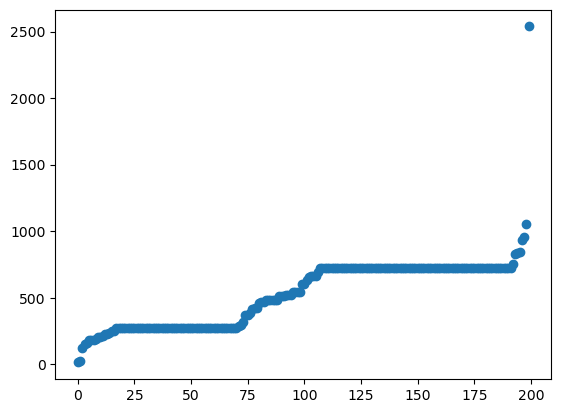

In [16]:
x=np.arange(0,200,1)
plt.scatter(x,np.array(sorted(wake_list))/60)

In [17]:
minte=np.array(sorted(wake_list))/60

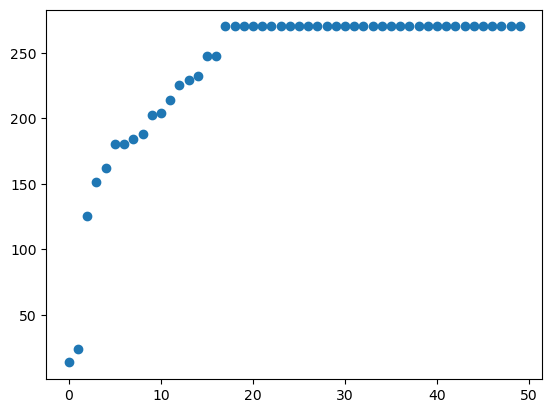

In [19]:
plt.scatter(np.arange(0,50,1),minte[0:50])
##可以看到最小的片段也有13分钟，可以说数据量是相当宽裕的